CUDA available: True
GPU: Tesla V100-SXM2-32GB

Raw dataset: DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})
Sample: {'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}

Data sizes:
  Train: 1629
  Valid: 182
  Test:  453

Number of labels: 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/tmp/pbs.2192.cbis-pbs/ipykernel_2537199/4185013954.py:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Model parameters:
  Trainable: 124,647,939
  Total: 124,647,939
  Trainable %: 100.00%

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.297500,0.180713,0.950549,0.926178
2,0.183600,0.099354,0.983516,0.973273
3,0.048900,0.096873,0.983516,0.978969



Evaluating on validation set...



Evaluating on test set...

VALIDATION RESULTS
Accuracy:  0.9835
Macro-F1:  0.9790
Loss:      0.0969

TEST RESULTS
Accuracy:  0.9713
Macro-F1:  0.9609

Classification Report (TEST):
              precision    recall  f1-score   support

           0     0.9500    0.9344    0.9421        61
           1     0.9891    0.9784    0.9837       278
           2     0.9407    0.9737    0.9569       114

    accuracy                         0.9713       453
   macro avg     0.9599    0.9622    0.9609       453
weighted avg     0.9716    0.9713    0.9714       453



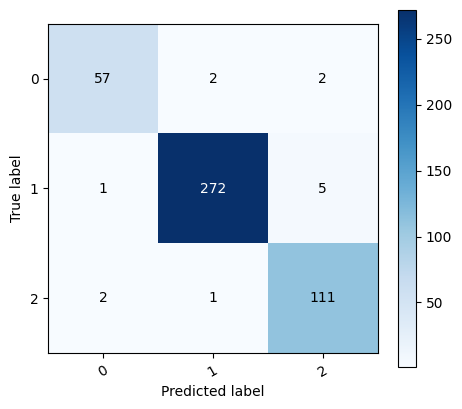


ERROR ANALYSIS
Total errors: 13
Error rate: 2.87%

First 10 errors (index, true_label, pred_label):
  Index 79: True=0, Pred=1
  Index 98: True=1, Pred=2
  Index 127: True=1, Pred=0
  Index 172: True=1, Pred=2
  Index 212: True=2, Pred=0
  Index 369: True=1, Pred=2
  Index 373: True=1, Pred=2
  Index 385: True=0, Pred=1
  Index 395: True=2, Pred=0
  Index 404: True=0, Pred=2

SUMMARY
Method: Full Fine-tuning
Model: roberta-base
Trainable params: 124,647,939 (100.00%)
Epochs: 3
Learning rate: 2e-05
Batch size: 16


In [1]:
# ============================================================
# RoBERTa Full Fine-tuning
# Dataset: Financial PhraseBank (Parquet format)
# Model: roberta-base
# Output: All metrics printed to console
# ============================================================

import random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Configuration
AGREE_SPLIT = "sentences_allagree"
PARQUET_PATH = f"hf://datasets/takala/financial_phrasebank@refs/convert/parquet/{AGREE_SPLIT}/train/*.parquet"

MODEL_NAME = "roberta-base"
SEED = 42
EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 256
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# ============================================================
# Load and split dataset
# ============================================================
raw = load_dataset("parquet", data_files={"train": PARQUET_PATH})
print("\nRaw dataset:", raw)
print("Sample:", raw["train"][0])

# Split: 72% train / 8% valid / 20% test
dataset_split = raw["train"].train_test_split(test_size=0.2, seed=SEED, stratify_by_column="label")
tmp = dataset_split["train"].train_test_split(test_size=0.1, seed=SEED, stratify_by_column="label")
train_ds, valid_ds, test_ds = tmp["train"], tmp["test"], dataset_split["test"]

print("\nData sizes:")
print(f"  Train: {len(train_ds)}")
print(f"  Valid: {len(valid_ds)}")
print(f"  Test:  {len(test_ds)}")

# ============================================================
# Tokenization
# ============================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_function(batch):
    return tokenizer(batch["sentence"], truncation=True, max_length=MAX_LEN)

train_tok = train_ds.map(tokenize_function, batched=True).rename_column("label", "labels")
valid_tok = valid_ds.map(tokenize_function, batched=True).rename_column("label", "labels")
test_tok = test_ds.map(tokenize_function, batched=True).rename_column("label", "labels")

keep = ["input_ids", "attention_mask", "labels"]
for ds in [train_tok, valid_tok, test_tok]:
    ds.remove_columns([c for c in ds.column_names if c not in keep])
    ds.set_format(type="torch", columns=keep)

num_labels = int(len(set(train_ds["label"])))
print(f"\nNumber of labels: {num_labels}")

# ============================================================
# Build model for full fine-tuning
# ============================================================
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"\nModel parameters:")
print(f"  Trainable: {trainable:,}")
print(f"  Total: {total:,}")
print(f"  Trainable %: {100.0 * trainable / total:.2f}%")

collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# ============================================================
# Training arguments
# ============================================================
args = TrainingArguments(
    output_dir="./ft_runs",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to=["none"],
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

# ============================================================
# Train model
# ============================================================
print("\nStarting training...")
trainer.train()

# ============================================================
# Evaluation
# ============================================================
print("\nEvaluating on validation set...")
dev_metrics = trainer.evaluate(valid_tok)

print("\nEvaluating on test set...")
pred = trainer.predict(test_tok)
y_true = np.array(test_ds["label"])
y_pred = np.argmax(pred.predictions, axis=-1)

acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")

print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
print(f"Accuracy:  {dev_metrics.get('eval_accuracy', 0.0):.4f}")
print(f"Macro-F1:  {dev_metrics.get('eval_f1_macro', 0.0):.4f}")
print(f"Loss:      {dev_metrics.get('eval_loss', 0.0):.4f}")

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Macro-F1:  {f1m:.4f}")

print("\nClassification Report (TEST):")
print(classification_report(y_true, y_pred, digits=4))

# ============================================================
# Confusion matrix
# ============================================================
labels_order = sorted(list(set(test_ds["label"])))
cm = confusion_matrix(y_true, y_pred, labels=labels_order)

fig, ax = plt.subplots(figsize=(4.8, 4.2))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=labels_order,
    yticklabels=labels_order,
    ylabel="True label",
    xlabel="Predicted label",
)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
thr = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center",
                color="white" if cm[i, j] > thr else "black")
fig.tight_layout()
plt.show()

# ============================================================
# Error analysis
# ============================================================
errors = [(i, int(gt), int(pd)) for i, (gt, pd) in enumerate(zip(y_true, y_pred)) if int(gt) != int(pd)]

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)
print(f"Total errors: {len(errors)}")
print(f"Error rate: {100.0 * len(errors) / len(y_true):.2f}%")
print(f"\nFirst 10 errors (index, true_label, pred_label):")
for idx, gt, pd in errors[:10]:
    print(f"  Index {idx}: True={gt}, Pred={pd}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Method: Full Fine-tuning")
print(f"Model: {MODEL_NAME}")
print(f"Trainable params: {trainable:,} ({100.0 * trainable / total:.2f}%)")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LR}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60)